# 16-6. 프로젝트 - Movielens 영화 SBR


Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템 제작

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
from pathlib import Path

import tensorflow
import warnings
warnings.filterwarnings('ignore')

print(tensorflow.__version__)

2.6.0


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.

data['Time'] = pd.to_datetime(data['Time'], unit='s') #시간 형식 변경


In [3]:
data.sample(5)

,UserId,ItemId,Rating,Time
774571,4620,1473,3,2000-07-20 20:10:10
276537,1671,2029,4,2002-07-19 21:08:44
9700,65,2471,4,2001-07-08 04:20:39
428300,2605,2716,2,2000-11-09 05:31:17
221733,1340,2021,1,2000-11-21 03:16:36


여기서 이전 실습 내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

Rating 정보가 포함되어 있습니다. 이전 실습 내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.

## Step 1. 데이터의 전처리


위와 같이 간단히 구성해 본 데이터셋을 꼼꼼히 살펴보면서 항목별 기본 분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [4]:
# 유저수, 아이템 수 확인
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [5]:
#각 유저가 대략 몇 개의 데이터를 갖는지 확인
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
ratings = data.groupby('Rating').size()
ratings

Rating
1     56174
2    107557
3    261197
4    348971
5    226310
dtype: int64

In [7]:
# rating 3이하 제거

min_rating = 3
data = data[data['Rating'] > 3] 

In [8]:
#중앙값, 평균, 최소, 최대
med, mean, mn, mx = (  session_length.median() 
                    , session_length.mean() 
                    , session_length.min()  
                    , session_length.max()
                    )
print(    f'중앙값: {med :.1f}\n'
          f'평균값: {mean:.1f}\n'
          f'최소값: {mn :.1f}\n'
          f'최대값: {mx :.1f}\n'
    )

중앙값: 96.0
평균값: 165.6
최소값: 20.0
최대값: 2314.0



In [9]:
# 분위수 (99.9%)

session_length.quantile(0.999)

1343.181000000005

In [10]:
# 최대값인 2314는 어떤 값인지 확인

long_session = session_length[session_length == 2314].index[0]
data[data['UserId'] == long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
696168,4169,3801,5,2000-08-03 20:11:21
...,...,...,...,...
697590,4169,1749,4,2002-03-18 22:47:36
696075,4169,2811,4,2002-03-18 22:59:38
696870,4169,3916,4,2002-04-07 20:38:20
697647,4169,3377,4,2002-04-07 20:53:08


먼가 초반에 보지도 않고 무작위로 누른 느낌적인 느낌이 있음.

Text(0.5, 1.0, 'Cumsum Percentage Until 0.999')

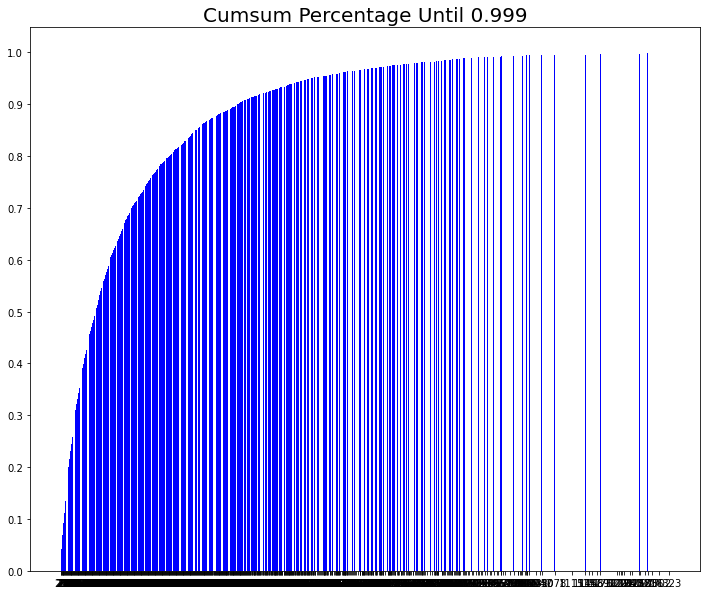

In [47]:
#하위 99.9% 세션 길이 분포 누적합 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

plt.figure(figsize = (12, 10))
plt.bar(x = length_percent_cumsum_999.index,
        height = length_percent_cumsum_999, color = 'blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.title('Cumsum Percentage Until 0.999', size=20)

In [12]:
# 시간 확인

oldest, latest = data['Time'].min(), data['Time'].max()

print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


'00년 4월 부터 '03년 2월까지 약 2년 10개월의 데이터

In [13]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
# Data Cleansing

# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_watch) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_watch)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_watch):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_watch].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [17]:
data = cleanse_recursive(data, shortest = 2, least_watch = 5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
36,1,1836,5,2000-12-31 22:02:52
...,...,...,...,...
1000119,6040,3671,4,2001-08-10 14:39:27
999923,6040,232,5,2001-08-10 14:39:58
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04


## Step 2. 미니 배치의 구성


실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [19]:
#test,val을 1달 기준 데이터로 나눔
tr, test = split_by_date(data, 180)
tr, val = split_by_date(tr, 180)

In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [21]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 472369
	 Users: 5572
	 Items: 3125
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-04 22:46:11

* valid Set Stats Info
	 Events: 29662
	 Users: 152
	 Items: 2597
	 First Time : 2000-04-30 06:38:59
	 Last Time : 2002-09-01 00:14:13

* test Set Stats Info
	 Events: 72353
	 Users: 313
	 Items: 2933
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [22]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df
    
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [23]:
# 저장

save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 3. 모델 구성

이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.



In [24]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [25]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
36,1,1836,5,2000-12-31 22:02:52,4
3,1,3408,4,2000-12-31 22:04:35,5
7,1,2804,5,2000-12-31 22:11:59,6
47,1,1207,4,2000-12-31 22:11:59,7
0,1,1193,5,2000-12-31 22:12:40,8
44,1,260,4,2000-12-31 22:12:40,9


In [26]:
tr_dataset.click_offsets

array([     0,     45,    118, ..., 472066, 472156, 472369], dtype=int32)

In [27]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5569, 5570, 5571])

In [28]:
# session data loader

class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=64):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1   # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=64)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
36,1,1836,5,2000-12-31 22:02:52,4
3,1,3408,4,2000-12-31 22:04:35,5
7,1,2804,5,2000-12-31 22:11:59,6
47,1,1207,4,2000-12-31 22:11:59,7
0,1,1193,5,2000-12-31 22:12:40,8
44,1,260,4,2000-12-31 22:12:40,9


In [30]:
iter_ex = iter(tr_data_loader)

In [31]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 45 52 22]
Label Item Idx are :       [  1  46 112  56]
Previous Masked Input Idx are []


## Step 4. 모델 학습


다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR(Mean Reciprocal Rank) 등의 개념들도 함께 관리될 수 있도록 합니다.
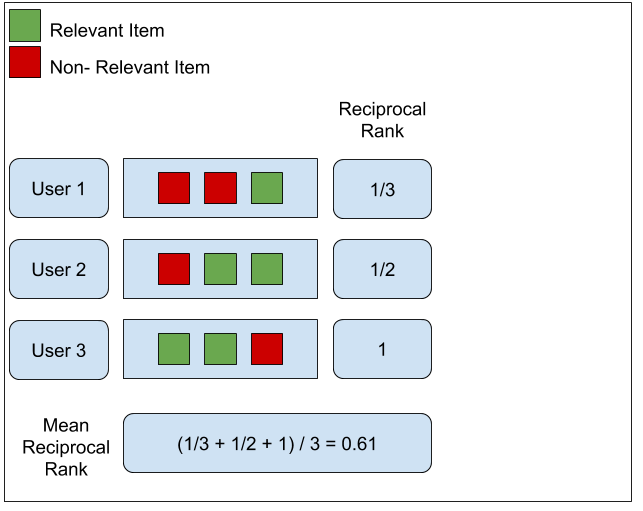 
<MRR : 추천한 값이 정답에서 몇번째에 위치하는 지 찾고 역수를 취한다음 평균> 

In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [33]:
# tensorflow import

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

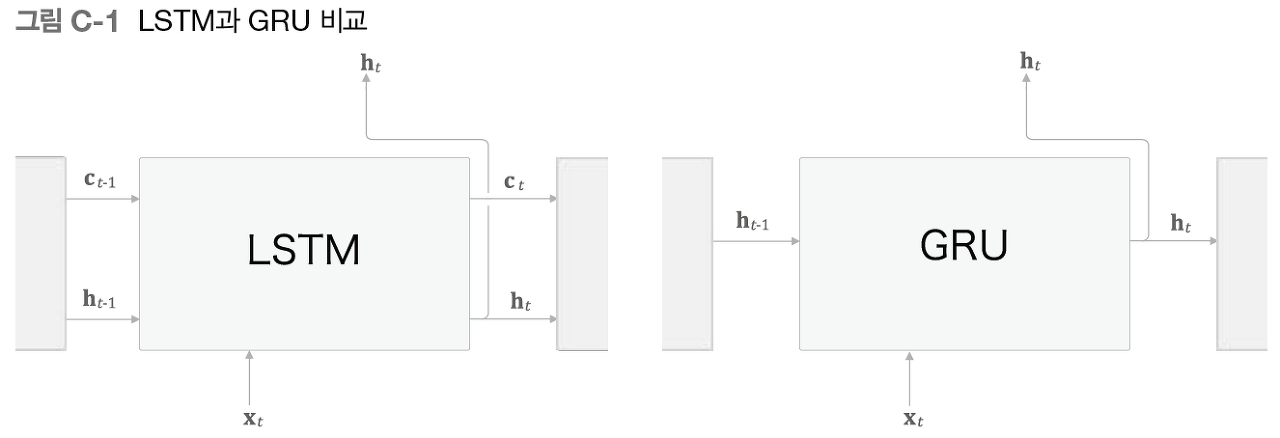  
GRU는 LSTM에서 존재했던 기억셀(c)를 삭제하고 파라메터 수를 줄인 모델.

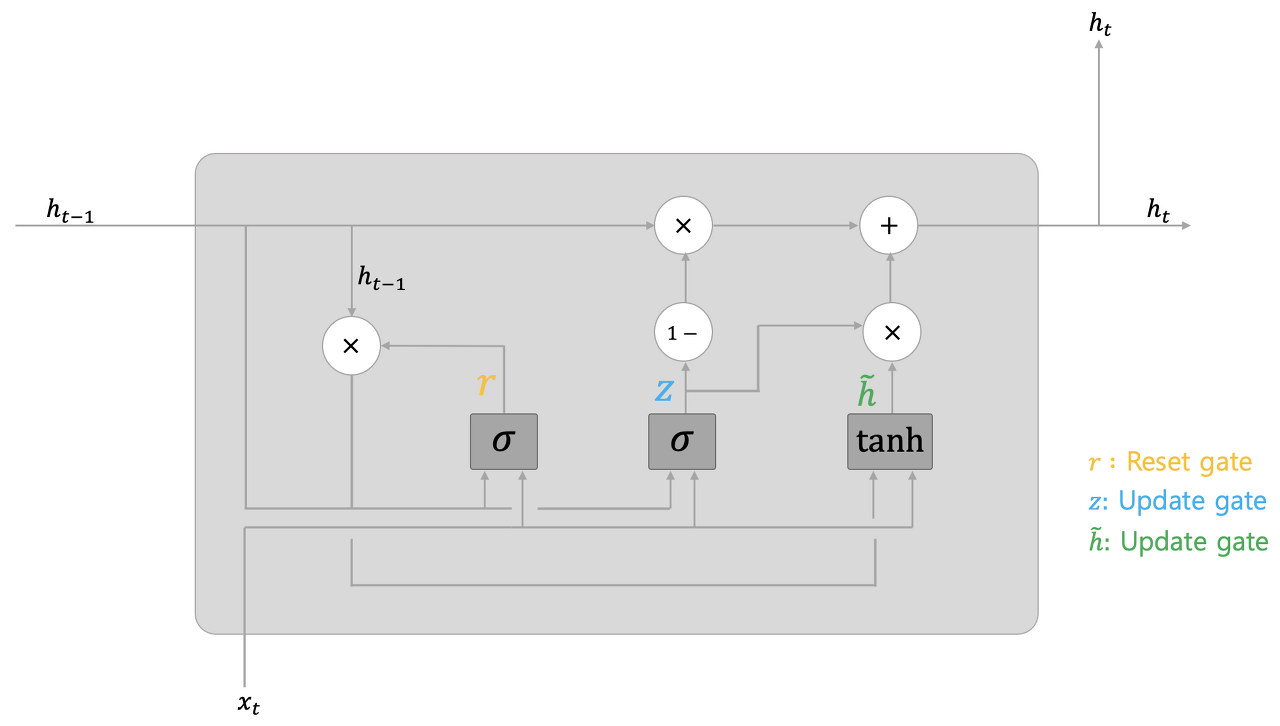

GRU는 총 2개의 게이트 존재. (Reset gate, Update gate)  
참고 : https://techblog-history-younghunjo1.tistory.com/486

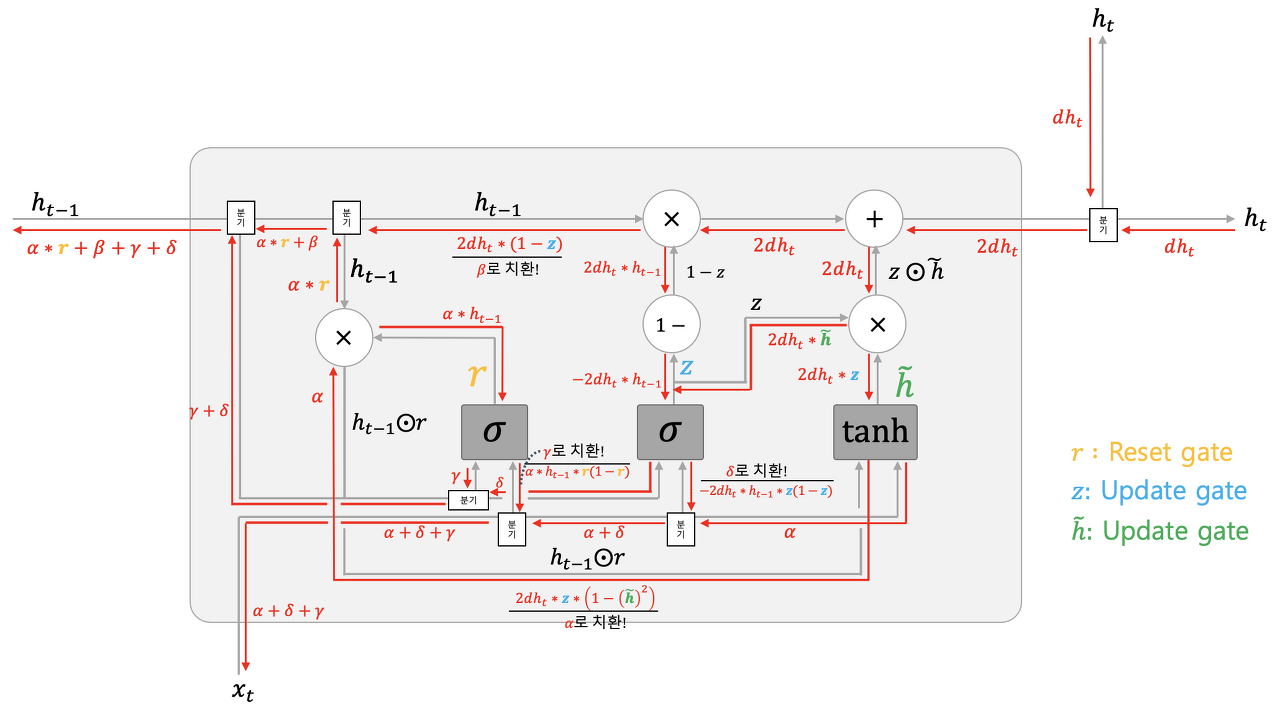

GRU back-propagation

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy
                  , optimizer=Adam(args.lr)
                  , metrics=['accuracy'])
    model.summary()
    
    return model

In [39]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50
            , drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [40]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3125)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      476550    
_________________________________________________________________
dropout_1 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (64, 3125)                159375    
Total params: 635,925
Trainable params: 635,925
Non-trainable params: 0
_________________________________________________________________


In [41]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size
                         , desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

## Step 5. 모델 테스트


미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.




In [42]:
train_model(model, args)

Evaluation:  72%|███████▏  | 331/461 [01:40<00:39,  3.29it/s]


	 - Recall@20 epoch 1: 0.184573
	 - MRR@20    epoch 1: 0.046436



Evaluation:  72%|███████▏  | 331/461 [01:37<00:38,  3.39it/s]


	 - Recall@20 epoch 2: 0.233856
	 - MRR@20    epoch 2: 0.061044



Evaluation:  72%|███████▏  | 331/461 [01:36<00:38,  3.42it/s]


	 - Recall@20 epoch 3: 0.253588
	 - MRR@20    epoch 3: 0.067820



Evaluation:  72%|███████▏  | 331/461 [01:36<00:37,  3.44it/s]


	 - Recall@20 epoch 4: 0.263076
	 - MRR@20    epoch 4: 0.071763



Evaluation:  72%|███████▏  | 331/461 [01:35<00:37,  3.48it/s]


	 - Recall@20 epoch 5: 0.266427
	 - MRR@20    epoch 5: 0.074091



Evaluation:  72%|███████▏  | 331/461 [01:34<00:37,  3.49it/s]


	 - Recall@20 epoch 6: 0.267938
	 - MRR@20    epoch 6: 0.075903



Evaluation:  72%|███████▏  | 331/461 [01:34<00:37,  3.50it/s]


	 - Recall@20 epoch 7: 0.270251
	 - MRR@20    epoch 7: 0.077124



Evaluation:  72%|███████▏  | 331/461 [01:34<00:37,  3.50it/s]


	 - Recall@20 epoch 8: 0.272517
	 - MRR@20    epoch 8: 0.078394



Evaluation:  72%|███████▏  | 331/461 [01:35<00:37,  3.48it/s]


	 - Recall@20 epoch 9: 0.271903
	 - MRR@20    epoch 9: 0.078207



Evaluation:  72%|███████▏  | 331/461 [01:35<00:37,  3.47it/s]

	 - Recall@20 epoch 10: 0.271054
	 - MRR@20    epoch 10: 0.078918



recal@20 최대값은 0.273 정도이고  
MRR@20 최대값은 0,079가 나왔습니다.  
train_loss는 6.31에서 5.66까지 점진적으로 줄어들고 있습니다.

## STEP 6. 모델 개선

### model_002

In [52]:
args = Args(tr
            , val
            , test
            , batch_size=64    
            , hsz=100           # 출력차원의 수 영향 살펴보기 50->100
            , drop_rate=0.1    
            , lr=0.001          
            , epochs=10       
            , k=20
           )
model_002 = create_model(args)
train_model(model_002, args)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(64, 1, 3125)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    968100    
_________________________________________________________________
dropout_6 (Dropout)          (64, 100)                 0         
_________________________________________________________________
dense_6 (Dense)              (64, 3125)                315625    
Total params: 1,283,725
Trainable params: 1,283,725
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 331/461 [01:37<00:38,  3.41it/s]


	 - Recall@20 epoch 1: 0.217051
	 - MRR@20    epoch 1: 0.056051



Evaluation:  72%|███████▏  | 331/461 [01:36<00:37,  3.42it/s]


	 - Recall@20 epoch 2: 0.254107
	 - MRR@20    epoch 2: 0.069133



Evaluation:  72%|███████▏  | 331/461 [01:35<00:37,  3.45it/s]


	 - Recall@20 epoch 3: 0.269213
	 - MRR@20    epoch 3: 0.075010



Evaluation:  72%|███████▏  | 331/461 [01:34<00:37,  3.51it/s]


	 - Recall@20 epoch 4: 0.275727
	 - MRR@20    epoch 4: 0.077225



Evaluation:  72%|███████▏  | 331/461 [01:34<00:37,  3.51it/s]


	 - Recall@20 epoch 5: 0.274830
	 - MRR@20    epoch 5: 0.078973



Evaluation:  72%|███████▏  | 331/461 [01:33<00:36,  3.53it/s]


	 - Recall@20 epoch 6: 0.274830
	 - MRR@20    epoch 6: 0.079558



Evaluation:  72%|███████▏  | 331/461 [01:34<00:36,  3.52it/s]


	 - Recall@20 epoch 7: 0.275963
	 - MRR@20    epoch 7: 0.079732



Evaluation:  72%|███████▏  | 331/461 [01:35<00:37,  3.46it/s]


	 - Recall@20 epoch 8: 0.273980
	 - MRR@20    epoch 8: 0.079583



Evaluation:  72%|███████▏  | 331/461 [01:33<00:36,  3.52it/s]


	 - Recall@20 epoch 9: 0.272753
	 - MRR@20    epoch 9: 0.078792



Evaluation:  72%|███████▏  | 331/461 [01:33<00:36,  3.56it/s]

	 - Recall@20 epoch 10: 0.271903
	 - MRR@20    epoch 10: 0.079040



hsz의 증가(50->100)는 모델 성능 개선에 유리합니다.  
recal@20 최대값 변화 : 0.273 -> 0.276    
MRR@20 최대값 변화   : 0,079 -> 0.0797  
train_loss 최소값 변화 : 5.66 -> 5.28 
  

<그리고 에폭은 5 정도로도 하이퍼파라메터의 영향을 알 수 있을 것 같습니다.  
이후 모델은 모두 epoch을 5로 해보겠습니다. (시간이 너무 많이 걸리네요 ㅠㅠ)>

### model_003

In [53]:
args = Args(tr
            , val
            , test
            , batch_size=128      # batch_size의 영향 살펴보기(1) : 64 -> 128 
            , hsz=50           
            , drop_rate=0.1    
            , lr=0.001          
            , epochs=5        
            , k=20
           )
model_003 = create_model(args)
train_model(model_003, args)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(128, 1, 3125)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    476550    
_________________________________________________________________
dropout_7 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_7 (Dense)              (128, 3125)               159375    
Total params: 635,925
Trainable params: 635,925
Non-trainable params: 0
_________________________________________________________________


Evaluation:  29%|██▉       | 67/230 [00:37<01:31,  1.79it/s]


	 - Recall@20 epoch 1: 0.182836
	 - MRR@20    epoch 1: 0.044480



Evaluation:  29%|██▉       | 67/230 [00:36<01:27,  1.86it/s]


	 - Recall@20 epoch 2: 0.254198
	 - MRR@20    epoch 2: 0.066784



Evaluation:  29%|██▉       | 67/230 [00:35<01:26,  1.88it/s]


	 - Recall@20 epoch 3: 0.288363
	 - MRR@20    epoch 3: 0.077621



Evaluation:  29%|██▉       | 67/230 [00:35<01:25,  1.91it/s]


	 - Recall@20 epoch 4: 0.303172
	 - MRR@20    epoch 4: 0.084267



Evaluation:  29%|██▉       | 67/230 [00:34<01:24,  1.92it/s]

	 - Recall@20 epoch 5: 0.310401
	 - MRR@20    epoch 5: 0.089379



batch_size의 증가(64->128)는 모델 성능 개선에 유리합니다.  
recal@20 최대값 변화 : 0.273 -> 0.31  
MRR@20 최대값 변화 : 0,079 -> 0.089  
train_loss 최소값 변화 : 5.66 -> 5.52  


### model_004

In [54]:
args = Args(tr
            , val
            , test
            , batch_size=32      # batch_size의 영향 살펴보기(2) : 64 -> 32  
            , hsz=50           
            , drop_rate=0.1    
            , lr=0.001          
            , epochs=5        
            , k=20
           )
model_004 = create_model(args)
train_model(model_004, args)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(32, 1, 3125)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      476550    
_________________________________________________________________
dropout_8 (Dropout)          (32, 50)                  0         
_________________________________________________________________
dense_8 (Dense)              (32, 3125)                159375    
Total params: 635,925
Trainable params: 635,925
Non-trainable params: 0
_________________________________________________________________


Evaluation:  85%|████████▍ | 782/922 [02:11<00:23,  5.96it/s]


	 - Recall@20 epoch 1: 0.195173
	 - MRR@20    epoch 1: 0.048319



Evaluation:  85%|████████▍ | 782/922 [02:07<00:22,  6.13it/s]


	 - Recall@20 epoch 2: 0.233416
	 - MRR@20    epoch 2: 0.062445



Evaluation:  85%|████████▍ | 782/922 [02:06<00:22,  6.19it/s]


	 - Recall@20 epoch 3: 0.244485
	 - MRR@20    epoch 3: 0.067756



Evaluation:  85%|████████▍ | 782/922 [02:09<00:23,  6.03it/s]


	 - Recall@20 epoch 4: 0.250719
	 - MRR@20    epoch 4: 0.070916



Evaluation:  85%|████████▍ | 782/922 [02:08<00:22,  6.10it/s]

	 - Recall@20 epoch 5: 0.253996
	 - MRR@20    epoch 5: 0.072109



batch_size의 감소(64->32)는 모델 개선에 불리해 보입니다.  
recal@20 최대값 변화 : 0.273 -> 0.253  
MRR@20 최대값 변화 : 0,079 -> 0.072  
train_loss 최소값 변화 : 5.66 -> 5.0  
  
물론, 아직 epoch이 작은 것이 아쉬울 수 있지만 이미 batch_size 128의 결과가 크게 개선된 것으로 보여 batch_size는 줄이는 것보다 조금 늘리는 것이 유리할 것으로 판단 됩니다.

### model_005

In [55]:
args = Args(tr
            , val
            , test
            , batch_size=64    
            , hsz=50           
            , drop_rate=0.2      # dropout 영향 살펴보기 : 0.1 -> 0.2    
            , lr=0.001          
            , epochs=5        
            , k=20
           )
model_005 = create_model(args)
train_model(model_005, args)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(64, 1, 3125)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      476550    
_________________________________________________________________
dropout_9 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_9 (Dense)              (64, 3125)                159375    
Total params: 635,925
Trainable params: 635,925
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 331/461 [01:41<00:39,  3.27it/s]


	 - Recall@20 epoch 1: 0.175840
	 - MRR@20    epoch 1: 0.043427



Evaluation:  72%|███████▏  | 331/461 [01:39<00:39,  3.32it/s]


	 - Recall@20 epoch 2: 0.231731
	 - MRR@20    epoch 2: 0.059223



Evaluation:  72%|███████▏  | 331/461 [01:38<00:38,  3.36it/s]


	 - Recall@20 epoch 3: 0.251322
	 - MRR@20    epoch 3: 0.067100



Evaluation:  72%|███████▏  | 331/461 [01:36<00:38,  3.42it/s]


	 - Recall@20 epoch 4: 0.260621
	 - MRR@20    epoch 4: 0.071005



Evaluation:  72%|███████▏  | 331/461 [01:36<00:37,  3.45it/s]

	 - Recall@20 epoch 5: 0.266994
	 - MRR@20    epoch 5: 0.074536



dropout의 증가(0.1 -> 0.2)는 모델 개선에 크게 유리해 보이지 않습니다.   
recal@20 최대값 변화 : 0.273 -> 0.266  
MRR@20 최대값 변화 : 0,079 -> 0.074   
train_loss 최소값 변화 : 5.66 -> 5.69


### model_006

In [56]:
args = Args(tr
            , val
            , test
            , batch_size=64    
            , hsz=50           
            , drop_rate=0.1    
            , lr=0.01            # 학습률 영향 살펴보기 0.001 -> 0.01 
            , epochs=5        
            , k=20
           )
model_006 = create_model(args)
train_model(model_006, args)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(64, 1, 3125)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      476550    
_________________________________________________________________
dropout_10 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_10 (Dense)             (64, 3125)                159375    
Total params: 635,925
Trainable params: 635,925
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 331/461 [01:37<00:38,  3.40it/s]


	 - Recall@20 epoch 1: 0.229843
	 - MRR@20    epoch 1: 0.060018



Evaluation:  72%|███████▏  | 331/461 [01:37<00:38,  3.40it/s]


	 - Recall@20 epoch 2: 0.231401
	 - MRR@20    epoch 2: 0.061373



Evaluation:  72%|███████▏  | 331/461 [01:39<00:39,  3.33it/s]


	 - Recall@20 epoch 3: 0.225925
	 - MRR@20    epoch 3: 0.059891



Evaluation:  72%|███████▏  | 331/461 [01:39<00:39,  3.33it/s]


	 - Recall@20 epoch 4: 0.224603
	 - MRR@20    epoch 4: 0.059206



Evaluation:  72%|███████▏  | 331/461 [01:38<00:38,  3.34it/s]

	 - Recall@20 epoch 5: 0.222574
	 - MRR@20    epoch 5: 0.059318



학습률의 증가(0.001 -> 0.01)는 모델 개선에 도움이 되지 않습니다.  
recal@20 최대값 변화 : 0.273 -> 0.232    
MRR@20 최대값 변화 : 0,079 -> 0.062  
train_loss 최소값 변화 : 5.66 -> 5.81  


### model_007

In [57]:
args = Args(tr
            , val
            , test
            , batch_size=64    
            , hsz=50           
            , drop_rate=0.1    
            , lr=0.001          
            , epochs=5        
            , k=40                # k값 영향 살펴보기 20 -> 40
           )
model_007 = create_model(args)
train_model(model_007, args)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(64, 1, 3125)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      476550    
_________________________________________________________________
dropout_11 (Dropout)         (64, 50)                  0         
_________________________________________________________________
dense_11 (Dense)             (64, 3125)                159375    
Total params: 635,925
Trainable params: 635,925
Non-trainable params: 0
_________________________________________________________________


Evaluation:  72%|███████▏  | 331/461 [02:42<01:03,  2.03it/s]


	 - Recall@40 epoch 1: 0.283138
	 - MRR@40    epoch 1: 0.049380



Evaluation:  72%|███████▏  | 331/461 [02:33<01:00,  2.16it/s]


	 - Recall@40 epoch 2: 0.347338
	 - MRR@40    epoch 2: 0.064825



Evaluation:  72%|███████▏  | 331/461 [02:30<00:58,  2.20it/s]


	 - Recall@40 epoch 3: 0.372781
	 - MRR@40    epoch 3: 0.071375



Evaluation:  72%|███████▏  | 331/461 [02:30<00:59,  2.20it/s]


	 - Recall@40 epoch 4: 0.383403
	 - MRR@40    epoch 4: 0.076147



Evaluation:  72%|███████▏  | 331/461 [02:28<00:58,  2.23it/s]

	 - Recall@40 epoch 5: 0.385102
	 - MRR@40    epoch 5: 0.077907



k값의 증가(20 -> 40)는 모델 개선에 도움이 되는 것으로 보입니다. 특히, recall이 크게 증가합니다.  
recal@20 최대값 변화 : 0.273 -> 0.385  
MRR@20 최대값 변화 : 0,079 -> 0.078  
train_loss 최소값 변화 : 5.66 -> 5.7  

##### 하이퍼 파라메터 정리  

|      |batch_size|hsz|drop_rate|Ir|k|
|--|--|--|--|--|--|
|최초 모델| 64|50|0.1|0.001|20|
|개선 방향|128|100|-|-|40|

### 최종 모델 선정

In [59]:
args = Args(tr
            , val
            , test
            , batch_size=128    
            , hsz=100           
            , drop_rate=0.1    
            , lr=0.001          
            , epochs=20        # 이제 epoch을 증가시켜 보겠습니다.
            , k=40                
           )
model_final = create_model(args)
train_model(model_final, args)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(128, 1, 3125)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  968100    
_________________________________________________________________
dropout_12 (Dropout)         (128, 100)                0         
_________________________________________________________________
dense_12 (Dense)             (128, 3125)               315625    
Total params: 1,283,725
Trainable params: 1,283,725
Non-trainable params: 0
_________________________________________________________________


Evaluation:  29%|██▉       | 67/230 [00:59<02:25,  1.12it/s]


	 - Recall@40 epoch 1: 0.340135
	 - MRR@40    epoch 1: 0.065908



Evaluation:  29%|██▉       | 67/230 [00:56<02:16,  1.19it/s]


	 - Recall@40 epoch 2: 0.408815
	 - MRR@40    epoch 2: 0.086640



Evaluation:  29%|██▉       | 67/230 [00:54<02:13,  1.22it/s]


	 - Recall@40 epoch 3: 0.433302
	 - MRR@40    epoch 3: 0.095213



Evaluation:  29%|██▉       | 67/230 [00:54<02:12,  1.23it/s]


	 - Recall@40 epoch 4: 0.446245
	 - MRR@40    epoch 4: 0.100240



Evaluation:  29%|██▉       | 67/230 [00:54<02:11,  1.24it/s]


	 - Recall@40 epoch 5: 0.452192
	 - MRR@40    epoch 5: 0.102710



Evaluation:  29%|██▉       | 67/230 [00:53<02:10,  1.25it/s]


	 - Recall@40 epoch 6: 0.454291
	 - MRR@40    epoch 6: 0.103084



Evaluation:  29%|██▉       | 67/230 [00:53<02:10,  1.25it/s]


	 - Recall@40 epoch 7: 0.456740
	 - MRR@40    epoch 7: 0.104732



Evaluation:  29%|██▉       | 67/230 [00:53<02:11,  1.24it/s]


	 - Recall@40 epoch 8: 0.454524
	 - MRR@40    epoch 8: 0.105166



Evaluation:  29%|██▉       | 67/230 [00:53<02:11,  1.24it/s]


	 - Recall@40 epoch 9: 0.452425
	 - MRR@40    epoch 9: 0.105638



Evaluation:  29%|██▉       | 67/230 [00:53<02:10,  1.24it/s]


	 - Recall@40 epoch 10: 0.449977
	 - MRR@40    epoch 10: 0.105018



Evaluation:  29%|██▉       | 67/230 [00:54<02:11,  1.24it/s]


	 - Recall@40 epoch 11: 0.450443
	 - MRR@40    epoch 11: 0.105474



Evaluation:  29%|██▉       | 67/230 [00:54<02:12,  1.23it/s]


	 - Recall@40 epoch 12: 0.448344
	 - MRR@40    epoch 12: 0.104357



Evaluation:  29%|██▉       | 67/230 [00:54<02:12,  1.23it/s]


	 - Recall@40 epoch 13: 0.446479
	 - MRR@40    epoch 13: 0.103768



Evaluation:  29%|██▉       | 67/230 [00:54<02:11,  1.24it/s]


	 - Recall@40 epoch 14: 0.445546
	 - MRR@40    epoch 14: 0.103457



Evaluation:  29%|██▉       | 67/230 [00:54<02:12,  1.23it/s]


	 - Recall@40 epoch 15: 0.444846
	 - MRR@40    epoch 15: 0.103215



Evaluation:  29%|██▉       | 67/230 [00:54<02:12,  1.23it/s]


	 - Recall@40 epoch 16: 0.442980
	 - MRR@40    epoch 16: 0.103675



Evaluation:  29%|██▉       | 67/230 [00:54<02:12,  1.23it/s]


	 - Recall@40 epoch 17: 0.439366
	 - MRR@40    epoch 17: 0.103212



Evaluation:  29%|██▉       | 67/230 [00:54<02:12,  1.23it/s]


	 - Recall@40 epoch 18: 0.438549
	 - MRR@40    epoch 18: 0.103179



Evaluation:  29%|██▉       | 67/230 [00:55<02:14,  1.21it/s]


	 - Recall@40 epoch 19: 0.437966
	 - MRR@40    epoch 19: 0.103364



Evaluation:  29%|██▉       | 67/230 [00:55<02:14,  1.21it/s]

	 - Recall@40 epoch 20: 0.435401
	 - MRR@40    epoch 20: 0.102853



recal@20 최대값 : 0.456  
MRR@20 최대값 : 0.1056  
train_loss 최소값 : 4.86  

## 고찰

1. SBR은 아이템과 유저 정보가 없는 상태에서도 추천을 할 수 있다는 점에서 흥미로웠습니다.  
2. 다만, 추천의 정확도가 높지 않은 점이 아쉬웠습니다.  
3. 이는 하이퍼 파라메터를 더 정교하게 수정하는 것으로 모델 개선이 가능하지 않을 까 생각합니다.  

감사합니다.